In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, pickle, time, warnings
import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

# Plotting modules
import matplotlib, corner
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# Plotting modules
font = {'family' : 'serif', 'weight' : 'normal',
        'size'   : 16}
legend = {'fontsize': 16}
matplotlib.rc('font', **font)
matplotlib.rc('legend', **legend)
plt.rc('text', usetex=True)
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)

cm_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

corner_kwargs = {'max_n_ticks':3, 'title_kwargs':{"fontsize": 16}, 'label_kwargs':{'fontsize':16}}

# Load thin disk Giant sample
Data generated in generate_population.py

In [3]:
size = 3000

In [4]:
sample = {}; true_pars={}; latent_pars={}; cmpt = 0
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample.h'
with h5py.File(filename, 'r') as hf:
    subset = (hf['sample']['cmpt'][...]==cmpt)&\
                (hf['sample']['M'][...]<hf['true_pars'][str(cmpt)]['Mto'][...])
    subsample  = np.sort(np.random.choice(np.arange(np.sum(subset)), size=size, replace=False))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset][subsample]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str): 
            true_pars[key]=hf['true_pars'][key][...]
        else:
            true_pars[key]={}
            for par in hf['true_pars'][key].keys():
                true_pars[key][par]=hf['true_pars'][key][par][...]

In [5]:
sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations

## Test with Toy Model code

In [43]:
labels = np.array( [r'$\log(\mathcal{N})$',  r'$\log(1/h_z)$', r'$\alpha$'])
functions = [lambda x:np.exp(x), lambda x:1/np.exp(x), None]

true_params = np.array([np.log(size), np.log(1/true_pars['0']['hz']), 
                        -true_pars['0']['alpha3']*5/np.log(10)])
# Toy Model code and Mock Model have alpha slightly differently defined.

true_params

array([8.00636757, 0.10536052, 0.21714724])

### Full sample

In [44]:
bounds = np.array([[-np.inf,        -np.inf,          0.],
                   [ np.inf,         np.inf,          3.]])

p0 = np.array( [transformations.logit(np.random.rand()),
                transformations.logit(np.random.rand()),
                np.random.rand()*3] )
p0

array([-1.52373008,  0.40084779,  1.64755415])

In [45]:
fid_pars = {'Mbol_max_true':true_pars[str(cmpt)]['Mto'],  'lat_min':np.deg2rad(true_pars['theta_deg'])}

In [9]:
sample_2d = np.vstack((1/sample['s'], np.arcsin(sample['sinb']),  sample['m']))

poisson_kwargs = {'sample':sample_2d, 'param_bounds':bounds, 
                  'logmodel':dcp.logmodel, 'model_integrate':dcp.integral_model, 
                  'bins':([0,np.inf],[-np.inf,np.inf]), 'fid_pars':fid_pars}

sampler_noerr = samplers.run_mcmc(p0, poisson_kwargs=poisson_kwargs, nstep=1000)

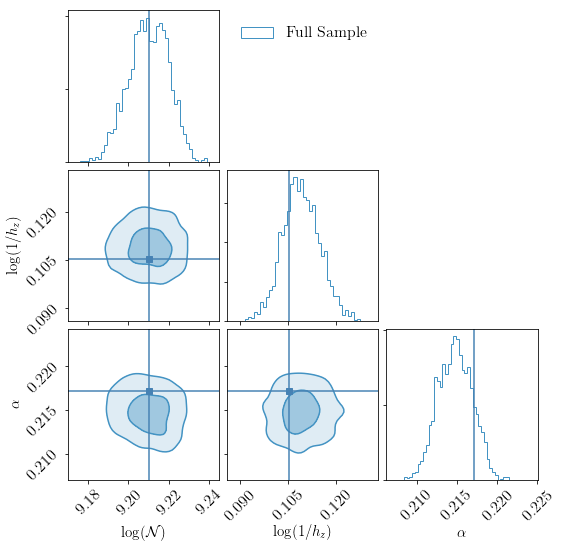

In [74]:
index = ['Full Sample']
plotting.layered_corners([sampler_noerr], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

### Parallax error

In [47]:
sample_2d = np.vstack((sample['parallax_obs'], np.arcsin(sample['sinb']),  sample['m'], sample['parallax_error']))

poisson_kwargs = {'sample':sample_2d, 'param_bounds':bounds, 
                  'logmodel':dcp.logmodel_perr, 'model_integrate':dcp.integral_model, 
                  'bins':([0,np.inf],[-np.inf,np.inf]), 'fid_pars':fid_pars}

sampler_perr = samplers.run_mcmc(p0, poisson_kwargs=poisson_kwargs, nstep=1000)

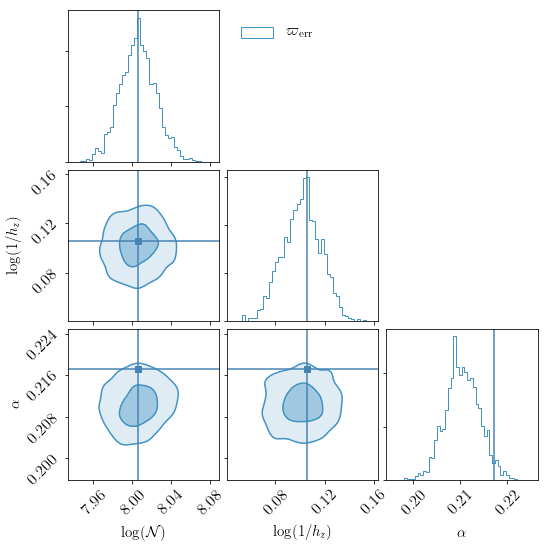

In [48]:
index = [r'$\varpi_\mathrm{err}$']
plotting.layered_corners([sampler_perr], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

## Run with mockmodel code

In [73]:
import disk_halo_mstogap as dh_msto

In [74]:
bounds = np.array([[-10, -10,         -5.],
                   [ 10,  10,          0.]])
labels = np.array( [r'$\log(\mathcal{N})$',  r'$\log(1/h_z)$', r'$\alpha$'])

In [75]:
fid_pars = {'Mmax':true_pars[str(cmpt)]['Mto'],  'lat_min':np.deg2rad(true_pars['theta_deg']),
            'R0':true_pars['R0'],
            'free_pars':{}, 'fixed_pars':{}, 'functions':{}, 'functions_inv':{}, 'jacobians':{}, 'w':True,
            'models':[dh_msto.log_expmodel_grad], 'components':['disk'], 'ncomponents':1}

fid_pars['free_pars'][0] = ['w', 'hz', 'alpha3']
fid_pars['free_pars']['shd'] = []

fid_pars['fixed_pars'][0] = {'Mms':100, 'fD':0., 'alpha1':0., 'alpha2':0.,
                             'Mms1':100, 'Mms2':100, 'Mto':true_pars['0']['Mto']}

print(' Free: ', fid_pars['free_pars'][0], ' Free shared: ', fid_pars['free_pars']['shd'], ' Fixed: ', fid_pars['fixed_pars'][0])

fid_pars['functions'][0] = {'hz':lambda x:np.exp(-x), 'alpha3':lambda x:x, 'w':lambda x: np.exp(x)}
fid_pars['functions_inv'][0] = {'hz':lambda x:np.log(1/x), 'alpha3':lambda x: x, 'w':lambda x: np.log(x)}
fid_pars['jacobians'][0] = {'alpha3':lambda x:x, 'w':lambda x:x,'hz':lambda x:x}

sample_2d = np.vstack((1/sample['s'], np.log(1/sample['s']),
                         sample['sinb'], np.log(np.sqrt(1-sample['sinb']**2)), 
                         sample['m']))

poisson_kwargs_global = {'sample':sample_2d,
                         'logmodel': dh_msto.logmodel_grad, 'model_integrate':dh_msto.integral_model,
                         'param_bounds':bounds, 'gmm':None, 'bins':([0,np.inf],[-np.inf,np.inf]),
                         'fid_pars':fid_pars, 'model_prior':None}

true_params = np.array([np.log(size), np.log(1/true_pars['0']['hz']), 
                        true_pars['0']['alpha3']])

 Free:  ['w', 'hz', 'alpha3']  Free shared:  []  Fixed:  {'Mms': 100, 'fD': 0.0, 'alpha2': 0.0, 'Mto': array(9.5), 'Mms1': 100, 'Mms2': 100, 'alpha1': 0.0}


In [76]:
def poisson_like(params, bounds=None, grad=False):

    poisson_kwargs = copy(poisson_kwargs_global)

    # Prior boundaries
    if bounds is None: bounds = poisson_kwargs['param_bounds']
    if np.sum((params<=bounds[0])|(params>=bounds[1]))>0:
        if grad: return -1e20, np.zeros(len(params))
        else: return -1e20

    # Optional prior inclusion
    if poisson_kwargs_global['model_prior'] is not None:
        prior=poisson_kwargs_global['model_prior'](params, fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    else: prior=0.

    integral = poisson_kwargs['model_integrate'](params, bins=poisson_kwargs['bins'], fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    obj = poisson_kwargs['logmodel'](poisson_kwargs['sample'], params, gmm=poisson_kwargs['gmm'], fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    
    if not grad: return np.sum(obj) - integral + prior

    elif grad:
        model_val = np.sum(obj[0]) - integral[0] + prior[0]
        model_grad = np.sum(obj[1], axis=1) - integral[1] + prior[1]
        return model_val, model_grad

In [77]:
bounds = np.array([[-10, -10,         -5.],
                   [ 10,  10,          0.]])
poisson_kwargs_global['param_bounds']=bounds

p0 = np.array( [transformations.logit(np.random.rand()),
                transformations.logit(np.random.rand()),
                -np.random.rand()*1] )
p0

array([ 0.34701717, -0.34892949, -0.25549611])

In [78]:
sampler = samplers.run_mcmc_global(p0, poisson_like, bounds, nstep=1000,
                                 ncores=1, notebook='notebook')

../models/disk_halo_mstogap.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  
../models/disk_halo_mstogap.py:84: RuntimeWarning: invalid value encountered in double_scalars
  a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);
../models/disk_halo_mstogap.py:101: RuntimeWarning: invalid value encountered in double_scalars
  alpha2*(Mms-Mto), alpha2*(Mms-Mms2)])
/home/andy/py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
../models/disk_halo_mstogap.py:104: RuntimeWarning: invalid value encountered in log
  
../models/disk_halo_mstogap.py:106: RuntimeWarning: invalid value encountered in log
  log_m = np.where(pop1, log_Ams - np.log(a1) + alpha1*(Mms+10-m_mu),


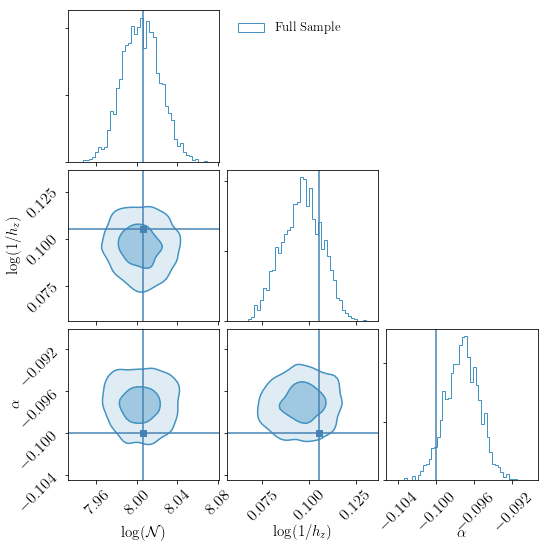

In [79]:
index = ['Full Sample']
plotting.layered_corners([sampler], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

### Parallax error

In [80]:
sample_2d = np.vstack((sample['parallax_obs'], sample['parallax_error'], 
                       np.abs(sample['sinb']), np.log(np.sqrt(1-sample['sinb']**2)), 
                       sample['m'], np.log(sample['parallax_error'])))

fid_pars['models']=[dh_msto.log_expmodel_perr]
poisson_kwargs_global = {'sample':sample_2d,
                         'logmodel': dh_msto.logmodel_perr, 'model_integrate':dh_msto.integral_model,
                         'param_bounds':bounds, 'gmm':None, 'bins':([0,np.inf],[-np.inf,np.inf]),
                         'fid_pars':fid_pars, 'model_prior':None}

true_params = np.array([np.log(size), np.log(1/true_pars['0']['hz']), 
                        true_pars['0']['alpha3']])

In [82]:
sampler = samplers.run_mcmc_global(p0, poisson_like, bounds, nstep=1000,
                                 ncores=1, notebook='notebook')

../models/disk_halo_mstogap.py:192: RuntimeWarning: divide by zero encountered in double_scalars
  
../models/disk_halo_mstogap.py:194: RuntimeWarning: invalid value encountered in double_scalars
  a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);
../models/disk_halo_mstogap.py:205: RuntimeWarning: invalid value encountered in double_scalars
  n3 = -(4 + alpha3*5/np.log(10))
/home/andy/py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
../models/disk_halo_mstogap.py:220: RuntimeWarning: invalid value encountered in log
  Mag_n =      [n3,  n2,   ng,   n1]
../models/disk_halo_mstogap.py:222: RuntimeWarning: invalid value encountered in log
  log_Ams - np.log(a2) + alpha2*(Mms+10-m_mu),
../utilities/functions.py:46: RuntimeWarning: divide by zero encountered in true_divide
  elif transform=='logit_ab': return (b-a)/((p-a)*(b-p))


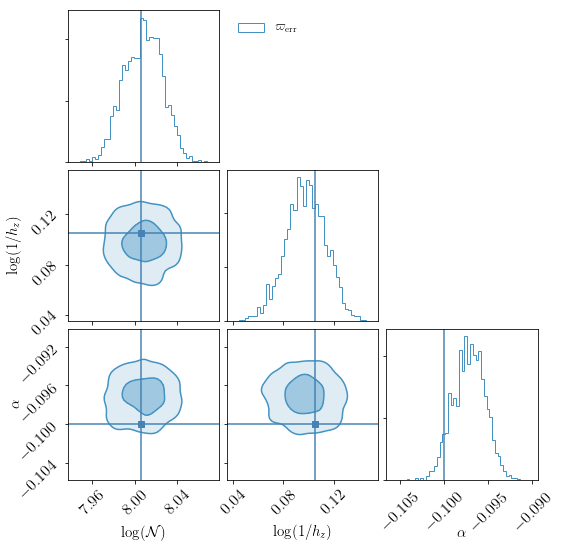

In [84]:
index = [r'$\varpi_\mathrm{err}$']
plotting.layered_corners([sampler], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

In [67]:
sample_2d = np.vstack((sample['parallax_obs'], sample['parallax_error'], 
                       np.abs(sample['sinb']), np.log(np.sqrt(1-sample['sinb']**2)), 
                       sample['m'], np.log(sample['parallax_error'])))

fid_pars['models']=[dh_msto.log_expmodel_perr_jitted]
poisson_kwargs_global = {'sample':sample_2d,
                         'logmodel': dh_msto.logmodel_perr_jitted, 'model_integrate':dh_msto.integral_model,
                         'param_bounds':bounds, 'gmm':None, 'bins':([0,np.inf],[-np.inf,np.inf]),
                         'fid_pars':fid_pars, 'model_prior':None}

true_params = np.array([np.log(size), np.log(1/true_pars['0']['hz']), 
                        true_pars['0']['alpha3']])

# Load Halo Giant sample
Data generated in generate_population.py

In [85]:
size = 1000

In [86]:
sample = {}; true_pars={}; latent_pars={}; cmpt = 2
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample.h'
with h5py.File(filename, 'r') as hf:
    subset = (hf['sample']['cmpt'][...]==cmpt)&\
                (hf['sample']['M'][...]<hf['true_pars'][str(cmpt)]['Mto'][...])
    subsample  = np.sort(np.random.choice(np.arange(np.sum(subset)), size=size, replace=False))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset][subsample]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str): 
            true_pars[key]=hf['true_pars'][key][...]
        else:
            true_pars[key]={}
            for par in hf['true_pars'][key].keys():
                true_pars[key][par]=hf['true_pars'][key][par][...]

In [87]:
sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations

In [427]:
true_params = np.array([np.log(size), np.log(true_pars['2']['hz']/3-1), 
                        true_pars['2']['alpha3']])
true_params

array([ 8.00636757, -0.62860866, -0.1       ])

## Run with mockmodel code

In [418]:
import disk_halo_mstogap as dh_msto

In [419]:
bounds = np.array([[-10, -10,         -5.],
                   [ 10,  10,          0.]])
labels = np.array( [r'$\log(\mathcal{N})$',  r'$\log(1/h_z)$', r'$\alpha$'])

In [432]:
fid_pars = {'Mmax':true_pars[str(cmpt)]['Mto'],  'lat_min':np.deg2rad(true_pars['theta_deg']),
            'R0':true_pars['R0'],
            'free_pars':{}, 'fixed_pars':{}, 'functions':{}, 'functions_inv':{}, 'jacobians':{}, 'w':True,
            'models':[dh_msto.log_halomodel_grad], 'components':['halo'], 'ncomponents':1}

fid_pars['free_pars'][0] = ['w', 'hz', 'alpha3']
fid_pars['free_pars']['shd'] = []

fid_pars['fixed_pars'][0] = {'Mms':100, 'fD':0., 'alpha1':0., 'alpha2':0.,
                             'Mms1':100, 'Mms2':100, 'Mto':true_pars['2']['Mto']}

print(' Free: ', fid_pars['free_pars'][0], ' Free shared: ', fid_pars['free_pars']['shd'], ' Fixed: ', fid_pars['fixed_pars'][0])

fid_pars['functions'][0] = {'hz':lambda x:3*(1+np.exp(x)), 'alpha3':lambda x:x, 'w':lambda x: np.exp(x)}
fid_pars['functions_inv'][0] = {'hz':lambda x:np.log(x/3 - 1), 'alpha3':lambda x: x, 'w':lambda x: np.log(x)}
fid_pars['jacobians'][0] = {'alpha3':lambda x:x, 'w':lambda x:x,'hz':lambda x:x}

sample_2d = np.vstack((1/sample['s'], np.log(1/sample['s']),
                         sample['sinb'], np.log(np.sqrt(1-sample['sinb']**2)), 
                         sample['m']))

poisson_kwargs_global = {'sample':sample_2d,
                         'logmodel': dh_msto.logmodel_grad, 'model_integrate':dh_msto.integral_model,
                         'param_bounds':bounds, 'gmm':None, 'bins':([0,np.inf],[-np.inf,np.inf]),
                         'fid_pars':fid_pars, 'model_prior':None}

 Free:  ['w', 'hz', 'alpha3']  Free shared:  []  Fixed:  {'Mms': 100, 'fD': 0.0, 'alpha2': 0.0, 'Mto': array(10.), 'Mms1': 100, 'Mms2': 100, 'alpha1': 0.0}


In [433]:
def poisson_like(params, bounds=None, grad=False):

    poisson_kwargs = copy(poisson_kwargs_global)

    # Prior boundaries
    if bounds is None: bounds = poisson_kwargs['param_bounds']
    if np.sum((params<=bounds[0])|(params>=bounds[1]))>0:
        if grad: return -1e20, np.zeros(len(params))
        else: return -1e20

    # Optional prior inclusion
    if poisson_kwargs_global['model_prior'] is not None:
        prior=poisson_kwargs_global['model_prior'](params, fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    else: prior=0.

    integral = poisson_kwargs['model_integrate'](params, bins=poisson_kwargs['bins'], fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    obj = poisson_kwargs['logmodel'](poisson_kwargs['sample'], params, gmm=poisson_kwargs['gmm'], fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    
    if not grad: return np.sum(obj) - integral + prior

    elif grad:
        model_val = np.sum(obj[0]) - integral[0] + prior[0]
        model_grad = np.sum(obj[1], axis=1) - integral[1] + prior[1]
        return model_val, model_grad

In [434]:
bounds = np.array([[-10, -10,         -5.],
                   [ 10,  10,          0.]])
poisson_kwargs_global['param_bounds']=bounds

p0 = np.array( [transformations.logit(np.random.rand()),
                transformations.logit(np.random.rand()),
                -np.random.rand()*1] )
p0

array([ 0.0172199 , -0.28158451, -0.45123144])

In [436]:
sampler = samplers.run_mcmc_global(p0, poisson_like, bounds, nstep=1000,
                                 ncores=1, notebook='notebook')

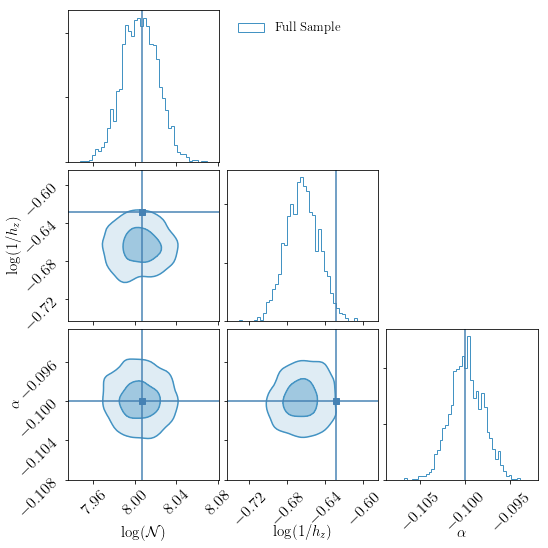

In [437]:
index = ['Full Sample']
plotting.layered_corners([sampler], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

### Parallax error

In [438]:
sample_2d = np.vstack((sample['parallax_obs'], sample['parallax_error'], 
                       np.abs(sample['sinb']), np.log(np.sqrt(1-sample['sinb']**2)), 
                       sample['m'], np.log(sample['parallax_error'])))

fid_pars['models']=[dh_msto.log_halomodel_perr]
poisson_kwargs_global = {'sample':sample_2d,
                         'logmodel': dh_msto.logmodel_perr, 'model_integrate':dh_msto.integral_model,
                         'param_bounds':bounds, 'gmm':None, 'bins':([0,np.inf],[-np.inf,np.inf]),
                         'fid_pars':fid_pars, 'model_prior':None}

In [589]:
bounds = np.array([[-10, -10,         -5.],
                   [ 10,  3,          0.]])
poisson_kwargs_global['param_bounds']=bounds

p0 = np.array( [transformations.logit(np.random.rand()),
                transformations.logit(np.random.rand()),
                -np.random.rand()*1] )
p0

array([-2.16830535, -0.12264723, -0.52686225])

In [590]:
poisson_like(p0)

-21931.33935717049

In [594]:
sampler = samplers.run_mcmc_global(p0, poisson_like, bounds, nstep=1000,
                                 ncores=1, notebook='notebook')

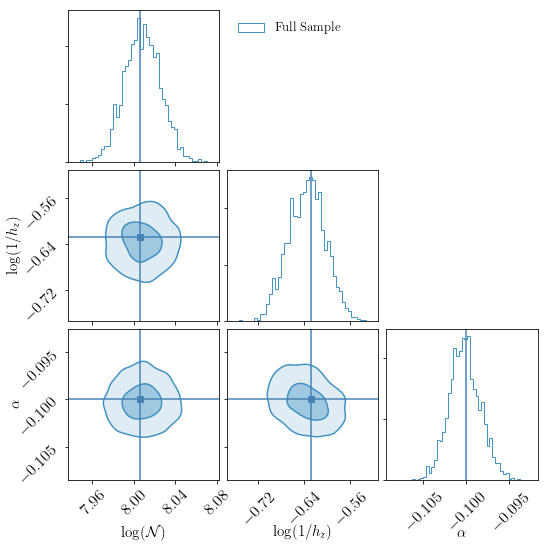

In [596]:
index = ['Full Sample']
plotting.layered_corners([sampler], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

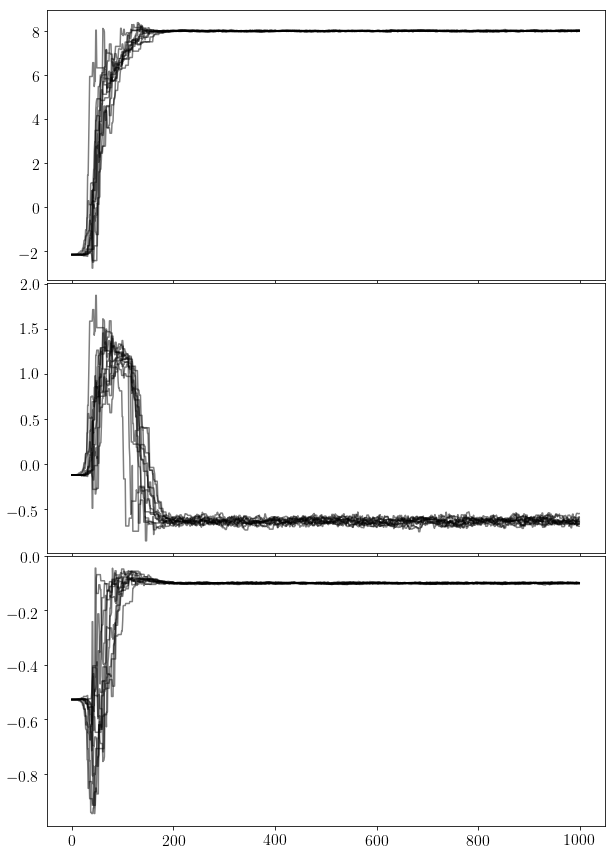

In [595]:
plotting.plot_chains(sampler)

In [439]:
p0=true_params

In [440]:
sampler = samplers.run_mcmc_global(p0, poisson_like, bounds, nstep=200,
                                 ncores=1, notebook='notebook')

../models/disk_halo_mstogap.py:478: RuntimeWarning: divide by zero encountered in double_scalars
  a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);
../models/disk_halo_mstogap.py:480: RuntimeWarning: invalid value encountered in double_scalars
  alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
../models/disk_halo_mstogap.py:489: RuntimeWarning: invalid value encountered in double_scalars
  log_Ams = np.log( fD*a1*a2 ) - \
../models/disk_halo_mstogap.py:505: RuntimeWarning: invalid value encountered in log
  log_Ams - np.log(a2) + alpha2*(Mms+10-m_mu),
../models/disk_halo_mstogap.py:507: RuntimeWarning: invalid value encountered in log
  log_Ams - np.log(a1) + alpha1*(Mms+10-m_mu)]


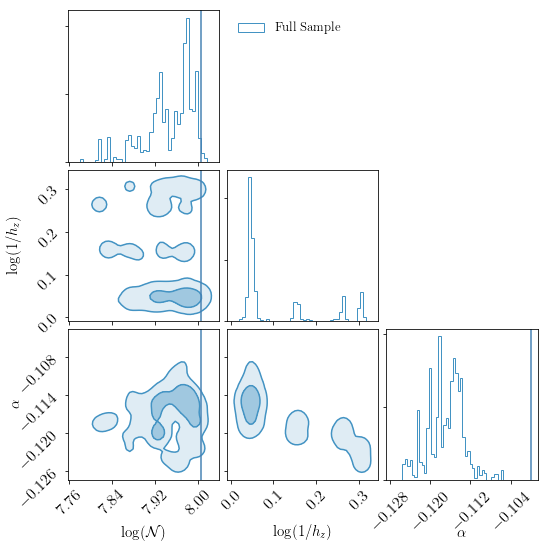

In [441]:
index = ['Full Sample']
plotting.layered_corners([sampler], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

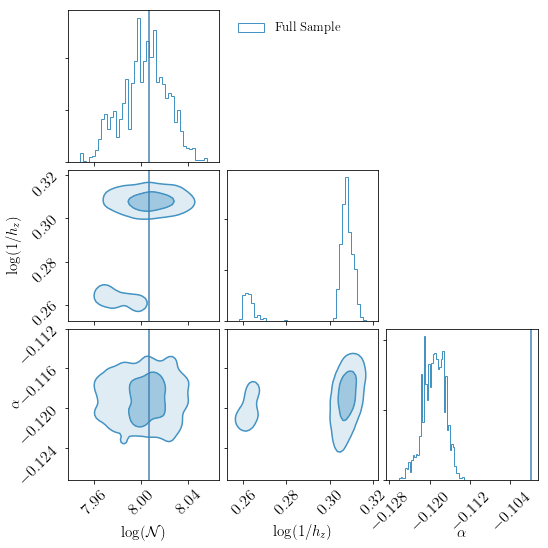

In [416]:
index = ['Full Sample']
plotting.layered_corners([sampler], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

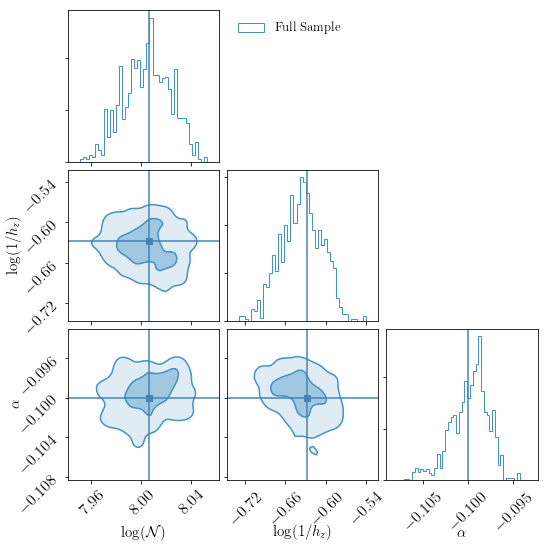

In [562]:
index = ['Full Sample']
plotting.layered_corners([sampler], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

In [500]:
poisson_like(true_params)

4.6 -0.1


../models/disk_halo_mstogap.py:480: RuntimeWarning: divide by zero encountered in double_scalars
  alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
../models/disk_halo_mstogap.py:482: RuntimeWarning: invalid value encountered in double_scalars
  
../models/disk_halo_mstogap.py:502: RuntimeWarning: invalid value encountered in double_scalars
  Mag_bounds = [-np.inf, Mto, Mms2, Mms1, Mx]
/home/andy/py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
../models/disk_halo_mstogap.py:513: RuntimeWarning: invalid value encountered in log
  
../models/disk_halo_mstogap.py:515: RuntimeWarning: invalid value encountered in log
  p_min = np.exp((Mag_bounds[ii  ]+10-m_mu)*np.log(10)/5)


13178.84588186995

In [507]:
poisson_like(np.array([8, 0.3, -0.12]))

7.049576422728009 -0.12


13685.001604298057

In [560]:
poisson_like(true_params)

4.6 -0.1


../models/disk_halo_mstogap.py:480: RuntimeWarning: divide by zero encountered in double_scalars
  alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
../models/disk_halo_mstogap.py:482: RuntimeWarning: invalid value encountered in double_scalars
  
../models/disk_halo_mstogap.py:495: RuntimeWarning: invalid value encountered in double_scalars
  a1/alpha2, -a1/alpha2]))
/home/andy/py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
../models/disk_halo_mstogap.py:506: RuntimeWarning: invalid value encountered in log
  log_Ams + np.log(Ag) + alphag*(Mms+10-m_mu),
../models/disk_halo_mstogap.py:508: RuntimeWarning: invalid value encountered in log
  


12351.101876542283

In [559]:
poisson_like(np.array([8, 0.3, -0.12]))

7.049576422728009 -0.12


../models/disk_halo_mstogap.py:480: RuntimeWarning: divide by zero encountered in double_scalars
  alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
../models/disk_halo_mstogap.py:482: RuntimeWarning: invalid value encountered in double_scalars
  
../models/disk_halo_mstogap.py:495: RuntimeWarning: invalid value encountered in double_scalars
  a1/alpha2, -a1/alpha2]))
/home/andy/py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
../models/disk_halo_mstogap.py:506: RuntimeWarning: invalid value encountered in log
  log_Ams + np.log(Ag) + alphag*(Mms+10-m_mu),
../models/disk_halo_mstogap.py:508: RuntimeWarning: invalid value encountered in log
  


11722.553738718816

In [485]:
poisson_like(p0)

13178.84588186995

In [409]:
dh_msto.logmodel_perr(sample_2d, p0, fid_pars=fid_pars)

../models/disk_halo_mstogap.py:478: RuntimeWarning: divide by zero encountered in double_scalars
  a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);
../models/disk_halo_mstogap.py:480: RuntimeWarning: invalid value encountered in double_scalars
  alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
../models/disk_halo_mstogap.py:489: RuntimeWarning: invalid value encountered in double_scalars
  log_Ams = np.log( fD*a1*a2 ) - \
/home/andy/py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
../models/disk_halo_mstogap.py:505: RuntimeWarning: invalid value encountered in log
  log_Ams - np.log(a2) + alpha2*(Mms+10-m_mu),
../models/disk_halo_mstogap.py:507: RuntimeWarning: invalid value encountered in log
  log_Ams - np.log(a1) + alpha1*(Mms+10-m_mu)]


array([ -3.83523148,  -4.59660256, -15.07703523, ...,   0.11161294,
        -3.6430658 , -12.05069732])

In [465]:
test_args = (1,3,2.,0.5,0.1,1.)
dh_msto.halomodel_perr_grad(0., *test_args[:-1]), dh_msto.halomodel_perr_grad(1., *test_args[:-1])

(0.05000000000000001, -0.9199999999999999)

In [467]:
test_args = (0.11459087188687923, -1.9315154043531053, 62.460138858539736, 
             -0.6133993246056172,  1.002678948333817, 0.5709469567273955)
grad = lambda x: dh_msto.halomodel_perr_logit_grad(x, test_args) \
               * dh_msto.halomodel_perr_integrand(x, *test_args[:-1])/(test_args[4]**2*(test_args[0]**2+x**2))
model = lambda x: x*(test_args[-1]-x)*dh_msto.halomodel_perr_integrand(x, *test_args[:-1])

In [470]:
x = 0.01
scipy.optimize.approx_fprime(np.array([x]),model,1e-12), grad(x)

(array([1.13767757e-61]), 1.1376772207309595e-61)

In [510]:
true_pars

{'0': {'Mto': array(9.5),
  'alpha3': array(-0.1),
  'fD': array(0.),
  'hz': array(0.9),
  'w': array(0.2)},
 '1': {'Mto': array(10.7),
  'alpha3': array(-0.3),
  'fD': array(0.),
  'hz': array(1.9),
  'w': array(0.3)},
 '2': {'Mto': array(10.),
  'alpha3': array(-0.1),
  'fD': array(0.),
  'hz': array(4.6),
  'w': array(0.5)},
 'Mms': array(8.),
 'Mms1': array(9.),
 'Mms2': array(7.),
 'Mx': array(10.7),
 'N': array(100000),
 'R0': array(8.27),
 'alpha1': array(-0.15),
 'alpha2': array(-0.3),
 'theta_deg': array(60)}

In [537]:
import functions

In [512]:
Mto=10
Mag_bounds = [-np.inf, Mto]

m_mu = sample['m']; pi_mu = sample['parallax_obs']; pi_err = sample['parallax_error']

hz = 5.2; R0=8.27
beta=sample['sinb']/R0

ii=0
p_min = np.exp((Mag_bounds[ii  ]+10-m_mu)*np.log(10)/5)
p_max = np.exp((Mag_bounds[ii+1]+10-m_mu)*np.log(10)/5)

args = (beta, n*np.ones(len(pi_mu)), hz*np.ones(len(pi_mu)), pi_mu, pi_err)
grad_min = dh_msto.halomodel_perr_grad(p_min, *args)
grad_max = dh_msto.halomodel_perr_grad(p_max, *args)
legendre = grad_min*grad_max>0

args = (beta[~legendre], n*np.ones(len(pi_mu[~legendre])),
                    hz*np.ones(len(pi_mu[~legendre])), pi_mu[~legendre], pi_err[~legendre], p_max[~legendre])

In [540]:
p_mode = functions.get_fooroots_ridder_hm(dh_msto.halomodel_perr_logit_grad, b=args[-1], 
                                          args=args)

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


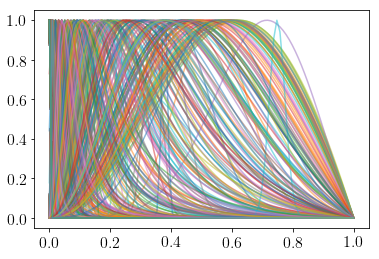

In [558]:
N=500
result = np.zeros((100,N))
for i in range(N):
    
    test_args = tuple([arg[i] for arg in args])
    #print(test_args)
    
    x = np.linspace(p_mode[i]*0.01,p_mode[i]*2,100)
    x = np.linspace(p_mode[i]*0.001,test_args[-1],100)
    
    result[:,i] = x*(test_args[-1]-x)*dh_msto.halomodel_perr_integrand(x, *test_args[:-1])
    y_grad = dh_msto.halomodel_perr_logit_grad(x, test_args)\
                * dh_msto.halomodel_perr_integrand(x, *test_args[:-1])/(test_args[4]**2*(test_args[0]**2+x**2))

result = result/np.max(result, axis=0)
for i in range(N): plt.plot(np.linspace(0,1,100), result[:,i], alpha=0.5,
                            label=r"$\mu=%.2f,\sigma=%.2f,\mu_\mathrm{max}=%.2f$"%tuple([args[j][i] for j in [3,4,5]]))
#plt.plot(x, y_grad, label='gradient')
#plt.legend(bbox_to_anchor=(1.1,1.))

In [ ]:
args = (beta[legendre], n*np.ones(len(pi_mu[legendre])),
                    hz*np.ones(len(pi_mu[legendre])), pi_mu[legendre], pi_err[legendre], p_max[legendre])
p_mode = functions.get_fooroots_ridder_hm(dh_msto.halomodel_perr_logit_grad, b=args[-1], 
                                          args=args)

In [ ]:
N=10
result = np.zeros((100,N))
for i in range(N):
    
    test_args = tuple([arg[i] for arg in args])
    #print(test_args)
    
    x = np.linspace(p_mode[i]*0.01,p_mode[i]*2,100)
    x = np.linspace(p_mode[i]*0.001,test_args[-1],100)
    
    result[:,i] = x*(test_args[-1]-x)*dh_msto.halomodel_perr_integrand(x, *test_args[:-1])
    y_grad = dh_msto.halomodel_perr_logit_grad(x, test_args)\
                * dh_msto.halomodel_perr_integrand(x, *test_args[:-1])/(test_args[4]**2*(test_args[0]**2+x**2))

result = result/np.max(result, axis=0)
for i in range(N): plt.plot(np.linspace(0,1,100), result[:,i], alpha=0.5,
                            label=r"$\mu=%.2f,\sigma=%.2f,\mu_\mathrm{max}=%.2f$"%tuple([args[j][i] for j in [3,4,5]]))
#plt.plot(x, y_grad, label='gradient')
#plt.legend(bbox_to_anchor=(1.1,1.))

In [519]:
test_args

(0.11459087188687923,
 -4.0,
 5.2,
 -0.6133993246056172,
 1.002678948333817,
 0.5709469567273955)

In [366]:
dh_msto.halomodel_perr_grad(0.570946, *test_args[:-1])

-0.06324799835807571

In [373]:
dh_msto.halomodel_perr_logit_grad(0.57, test_args)

0.40801351892419896

In [394]:
grad = lambda x: dh_msto.halomodel_perr_logit_grad(x, test_args) \
               * dh_msto.halomodel_perr_integrand(x, *test_args[:-1]) / test_args[4]**2 \
                / (test_args[0]**2 + x**2)
# grad = lambda x: dh_msto.halomodel_perr_logit_grad(x, test_args) \
#                * dh_msto.halomodel_perr_integrand(x, *test_args[:-1]) *x*(test_args[-1]-x)
model = lambda x: x*(test_args[-1]-x)*dh_msto.halomodel_perr_integrand(x, *test_args[:-1])

In [398]:
scipy.optimize.approx_fprime(np.array([0.57]),model,1e-10), grad(0.57)

(array([-0.24375926]), -0.2437592353982083)

In [355]:
dh_msto.halomodel_perr_logit_grad(0., test_args), dh_msto.halomodel_perr_logit_grad(1., test_args)

(0.06000000000000001, -1.0)

In [374]:
grad = lambda x: dh_msto.halomodel_perr_grad(x, *test_args[:-1]) \
               * dh_msto.halomodel_perr_integrand(x, *test_args[:-1]) / test_args[4]**2 / x
model = lambda x: dh_msto.halomodel_perr_integrand(x, *test_args[:-1])

In [375]:
scipy.optimize.approx_fprime(np.array([0.0001]),model,1e-10), grad(0.0001)

(array([1.3044577e-182]), 2.2999069747811263e-178)

In [347]:
grad = lambda x: dh_msto.halomodel_perr_logit_grad(x, test_args) \
               * dh_msto.halomodel_perr_integrand(x, *test_args[:-1])*x*(test_args[-1]-x)
grad = lambda x: dh_msto.halomodel_perr_logit_grad(x, test_args) \
               * dh_msto.halomodel_perr_integrand(x, *test_args[:-1])/(err**2*(beta**2+x**2))
model = lambda x: x*(test_args[-1]-x)*dh_msto.halomodel_perr_integrand(x, *test_args[:-1])

In [348]:
scipy.optimize.approx_fprime(np.array([0.001]),model,1e-10), grad(0.001)

(array([2.36730022e-20]), 2.3681026749752762e-20)

In [332]:
grad = lambda x: dh_msto.halomodel_perr_logit_grad(x, test_args) \
               * dh_msto.halomodel_perr_integrand(x, *test_args[:-1]) / test_args[4]**2 / x \
                / (test_args[0]**2 + x**2)
model = lambda x: x*(test_args[-1]-x)*dh_msto.halomodel_perr_integrand(x, *test_args[:-1])

In [333]:
scipy.optimize.approx_fprime(np.array([0.01]),model,1e-10), grad(0.01)

(array([3.92140191e-15]), 1.5460566668459659e-09)

In [327]:
grad = lambda x: dh_msto.halomodel_perr_logit_grad(x, test_args) \
               * dh_msto.halomodel_perr_integrand(x, *test_args[:-1])
model = lambda x: x*(test_args[-1]-x)*dh_msto.halomodel_perr_integrand(x, *test_args[:-1])

In [328]:
scipy.optimize.approx_fprime(np.array([0.01]),model,1e-6), grad(0.01)

(array([3.92249059e-15]), 1.5462112725126508e-13)

In [324]:
def foo(p, beta, h, n, mu, err,pmax):
    return p*(pmax-p)*p**n * (beta**2/p**2 + 1)**(-h/2) * np.exp(-(p-mu)**2 / (2*err**2))
def foograd(p, beta, h, n, mu, err,pmax):
    return  + h*beta**2/(p) * (beta**2+p**2)**(- 1) - 2*(p-mu)/(2*err**2)

In [325]:
args=(1,2,0.5,0.1,-4,1)
model = lambda x: foo(x,*args)
grad = lambda x: foograd(x,*args)*foo(x,*args)

In [326]:
scipy.optimize.approx_fprime(np.array([0.01]),model,1e-6), grad(0.01)

(array([3.45406738e-05]), 9.895082304513529e-06)

In [292]:
def foo(p, beta, h):
    return (beta**2/p**2 + 1)**(-h/2)
def foograd(p, beta, h):
    return h*beta**2/(p) * (beta**2+p**2)**(- 1)

In [211]:
dh_msto.halomodel_perr_logit_grad(0., test_args), dh_msto.halomodel_perr_logit_grad(1., test_args)

(2.0, 0.98)

In [ ]:
scipy.

In [198]:
dh_msto.logmodel_perr(sample_2d[:,[10,72,77]], p0, fid_pars=fid_pars)

../models/disk_halo_mstogap.py:347: RuntimeWarning: divide by zero encountered in double_scalars
  a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);
../models/disk_halo_mstogap.py:349: RuntimeWarning: invalid value encountered in double_scalars
  alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
../models/disk_halo_mstogap.py:358: RuntimeWarning: invalid value encountered in double_scalars
  log_Ams = np.log( fD*a1*a2 ) - \
/home/andy/py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
../models/disk_halo_mstogap.py:374: RuntimeWarning: invalid value encountered in log
  log_Ams - np.log(a2) + alpha2*(Mms+10-m_mu),
../models/disk_halo_mstogap.py:376: RuntimeWarning: invalid value encountered in log
  log_Ams - np.log(a1) + alpha1*(Mms+10-m_mu)]


[-0.79906966 -0.04119758 -0.19545248] [0.06325143 0.06542945 0.23130575]


../utilities/functions.py:32: RuntimeWarning: divide by zero encountered in true_divide
  elif transform=='logit_ab': return np.log((p-a)/(b-p))
../utilities/functions.py:46: RuntimeWarning: divide by zero encountered in true_divide
  elif transform=='logit_ab': return (b-a)/((p-a)*(b-p))
../models/disk_halo_mstogap.py:411: RuntimeWarning: invalid value encountered in true_divide
  p_mode = functions.get_fooroots_ridder_hm(halomodel_perr_logit_grad, a=a, b=b, args=args)


array([nan, nan, nan])

In [180]:
poisson_like(p0)

../models/disk_halo_mstogap.py:347: RuntimeWarning: divide by zero encountered in double_scalars
  a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);
../models/disk_halo_mstogap.py:349: RuntimeWarning: invalid value encountered in double_scalars
  alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
../models/disk_halo_mstogap.py:358: RuntimeWarning: invalid value encountered in double_scalars
  log_Ams = np.log( fD*a1*a2 ) - \
/home/andy/py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
../models/disk_halo_mstogap.py:374: RuntimeWarning: invalid value encountered in log
  log_Ams - np.log(a2) + alpha2*(Mms+10-m_mu),
../models/disk_halo_mstogap.py:376: RuntimeWarning: invalid value encountered in log
  log_Ams - np.log(a1) + alpha1*(Mms+10-m_mu)]
../utilities/functions.py:32: RuntimeWarning: divide by zero encountered 

[ -1.3557135   -3.25728905 -14.74110036 ...   2.56727366 -35.14510205
          nan]


../utilities/functions.py:46: RuntimeWarning: divide by zero encountered in true_divide
  elif transform=='logit_ab': return (b-a)/((p-a)*(b-p))


nan

In [ ]:
sampler = samplers.run_mcmc_global(p0, poisson_like, bounds, nstep=1000,
                                 ncores=1, notebook='notebook')

../models/disk_halo_mstogap.py:192: RuntimeWarning: divide by zero encountered in double_scalars
  
../models/disk_halo_mstogap.py:194: RuntimeWarning: invalid value encountered in double_scalars
  a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);
../models/disk_halo_mstogap.py:205: RuntimeWarning: invalid value encountered in double_scalars
  n3 = -(4 + alpha3*5/np.log(10))
/home/andy/py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
../models/disk_halo_mstogap.py:220: RuntimeWarning: invalid value encountered in log
  Mag_n =      [n3,  n2,   ng,   n1]
../models/disk_halo_mstogap.py:222: RuntimeWarning: invalid value encountered in log
  log_Ams - np.log(a2) + alpha2*(Mms+10-m_mu),
../utilities/functions.py:46: RuntimeWarning: divide by zero encountered in true_divide
  elif transform=='logit_ab': return (b-a)/((p-a)*(b-p))


In [ ]:
index = [r'$\varpi_\mathrm{err}$']
plotting.layered_corners([sampler], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

# Runtime test

In [342]:
from numba import njit

In [382]:
def test_nojit(x):
    
    result = np.zeros((len(x)))
    
    for ii in range(len(x)):
        result[ii] = x[ii]**5
            
    return result

@njit
def test_jit(x):
    
    result = np.zeros((len(x)))
    
    for ii in range(len(x)):
        result[ii] = x[ii]**5
            
    return result

In [390]:
x = np.linspace(0,1,10000000)

In [386]:
%timeit test_nojit(x)

62.6 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [391]:
%timeit test_jit(x)

55.3 ms ± 908 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [392]:
@njit
def test_2(x, result):
    
    for ii in range(len(x)):
        result[ii] = x[ii]**5
            
    return result

In [393]:
result = np.zeros((len(x)))
%timeit test_2(x, result)

17.2 ms ± 86.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
